We noticed differences in the surface current between GLORYS12 and PSY4 on July 8, 2019. How persistent are these differences? Are the around in the monthly mean, yearly, year to year?

Plan:
* Look at July 2019 monthly mean and std
* Look at every month and year available? (PSY4 is limited)

In [1]:
import datetime
import glob
import os

import geopy.distance
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

In [2]:
# Settings for this transect
TRANSECT='SealIsland'
STATIONS = pd.read_table('../data/csv/transects/{}/{}.txt'.format(TRANSECT, TRANSECT.lower()), 
                         delimiter=' ')

glorys_path='/data/cmems/my.cmems-du.eu/GLOBAL_MULTIYEAR_PHY_001_030/cmems_mod_glo_phy_my_0.083_P1D-m/'
psy4_path='/data/cmems/nrt.cmems-du.eu/GLOBAL_ANALYSIS_FORECAST_PHY_001_024/global-analysis-forecast-phy-001-024/'
glorys_coords='/data/cmems/my.cmems-du.eu/GLOBAL_MULTIYEAR_PHY_001_030/cmems_mod_glo_phy_my_0.083-static/GLO-MFC_001_030_coordinates.nc'
psy4_coords='/data/cmems/nrt.cmems-du.eu/GLOBAL_ANALYSIS_FORECAST_PHY_001_024/global-analysis-forecast-phy-001-024-statics/GLO-MFC_001_024_coordinates.nc'
glorys_mask='/data/cmems/my.cmems-du.eu/GLOBAL_MULTIYEAR_PHY_001_030/cmems_mod_glo_phy_my_0.083-static/GLO-MFC_001_030_mask_bathy.nc'
psy4_mask='/data/cmems/nrt.cmems-du.eu/GLOBAL_ANALYSIS_FORECAST_PHY_001_024/global-analysis-forecast-phy-001-024-statics/GLO-MFC_001_024_mask_bathy.nc'


In [3]:
lon_min=-65
lat_min=45
lon_max=-45
lat_max=60

In [4]:
# etopo file
ef = '/home/soontiensn/data/ocn-nav/ETOPO1_Bed_g_gmt4.grd'
etopo = xr.open_dataset(ef)
esel = etopo.sel(x=slice(lon_min, lon_max), y=slice(lat_min, lat_max))

In [5]:
def interp_to_stations(d, stations):
    # Use xarray to do interpolation
    interp = d.interp(longitude=stations.LON.values, latitude=stations.LAT.values)
    # The interpolation was done on a grid so now isolate the stations and build new dataset
    dall = xr.Dataset()
    lats=[]
    lons=[]
    sids=[]
    for i in range(stations.shape[0]):
        lat=stations.iloc[i]['LAT']
        lon=stations.iloc[i]['LON']
        lats.append(lat)
        lons.append(lon)
        sid=stations.iloc[i]['STATION']
        sids.append(sid)
        d = interp.sel(longitude=lon, latitude=lat)
        #d = d.expand_dims(dim='stationID')
        d = d.reset_coords(names=['longitude', 'latitude'])
        #d['stationID'] = xr.DataArray([sid], dims='stationID')
        dall = xr.concat([dall,d],'stationID')
    # Add lon,lat,stationID ass coordinates
    dall['longitude'] = xr.DataArray(lons, dims='stationID')
    dall['latitude'] = xr.DataArray(lats, dims='stationID')
    dall['stationID'] = xr.DataArray(sids, dims='stationID')
    dall = dall.assign_coords(longitude=dall.longitude)
    dall = dall.assign_coords(latitude=dall.latitude)
    dall = dall.assign_coords(stationID=dall.stationID)
    # Add distance along transect
    numstations=stations.shape[0]
    distance = [geopy.distance.distance((stations.iloc[0]['LAT'], stations.iloc[0]['LON']),
                                    (stations.iloc[i]['LAT'], stations.iloc[i]['LON'])).km for i in range(numstations)]
    dall['distance'] = xr.DataArray(distance, dims='stationID', attrs={'long_name': 'Distance',
                                                                   'units': 'km',
                                                                   'comment': 'Distance along transect from the coast'})
    dall = dall.assign_coords(distance=dall.distance)
    dall['speed'] = np.sqrt(dall['uo']**2 + dall['vo']**2)
    dall['speed'].attrs = {'long_name': 'speed', 'units': 'm/s'}
    return dall

In [6]:
def plot_transect(d, ax, vmin=0, vmax=.5, label='Speed [m/s]', cmap='YlGnBu_r', CIL=True):
    d.speed.plot.contourf(
        x='distance',
        y='depth',
        cmap=cmap,
        levels=np.linspace(vmin,vmax,num=15),
        cbar_kwargs={'label': label}, 
        ax=ax)
    if CIL:
        d.thetao.plot.contour(
            x='distance', 
            y='depth',
            levels=[0,],
            colors='k',
            ax=ax)
    ax.set_ylim([500,0])
    ax.grid()
    ax.plot(d.distance, np.zeros(d.distance.shape), 'ro')

In [7]:
def plot_hovmoller(d, ax, var='speed', vmin=0, vmax=.5, cmap='YlGnBu_r'):
    d[var].plot.contourf(
        x='distance',
        y='time',
        levels=np.linspace(vmin,vmax,num=15),
        cmap=cmap,ax=ax)
    top=[d.time.values[-1] for i in range(d.distance.shape[0])]
    ax.plot(d.distance,top, 'ro')
    ax.grid()

In [8]:
def plot_bathymetry(ax, etopo):
    lons = etopo.x.values
    lats = etopo.y.values
    lons, lats = np.meshgrid(lons,lats)
    bathy = etopo.z.values
    levels = [-1000,-500, -200]
    CS = ax.contour(lons,lats,bathy,levels, linestyles='solid', linewidths=1,colors='k')
    #ax.clabel(CS, CS.levels, inline=True, fmt='%1.0f', fontsize=12)

In [9]:
def load_data(year, month, path, coords, mask, outfile, save=True,
              lon_min=-65, lon_max=-45, lat_min=45, lat_max=60):
    outfile_main = '{}.nc'.format(outfile)
    depav_file = '{}_depav.nc'.format(outfile)
    if not os.path.exists(outfile_main):
        # data
        files =  glob.glob(os.path.join(path, '{}/{}/*{}{}*_*.nc'.format(year,month,year,month)))
        files.sort()
        d = xr.open_mfdataset(files).sel(latitude=slice(lat_min, lat_max), longitude=slice(lon_min,lon_max))
        if save:
            d.to_netcdf(outfile_main)
        
        # coords
        d_coords = xr.open_dataset(coords).sel(latitude=slice(lat_min, lat_max), 
                                               longitude=slice(lon_min,lon_max))
        d_mask = xr.open_dataset(mask).sel(latitude=slice(lat_min, lat_max), 
                                       longitude=slice(lon_min,lon_max))
        
        #depav
        udepav = (d.uo * d_coords.e3t * d_mask.mask).sum(dim='depth')/( d_coords.e3t * d_mask.mask).sum(dim='depth')
        vdepav = (d.vo * d_coords.e3t * d_mask.mask).sum(dim='depth')/( d_coords.e3t * d_mask.mask).sum(dim='depth')
        speed = np.sqrt(udepav**2 + vdepav**2)
        d_depav = xr.Dataset()
        d_depav['uo'] = udepav
        d_depav['vo'] = vdepav
        d_depav.attrs['source'] = d.source
        if save:
            d_depav.to_netcdf(depav_file)
    else:
        d = xr.open_dataset(outfile_main)
        d_depav = xr.open_dataset(depav_file)
    return d, d_depav

In [10]:
def compare_area(d1, d2, level=0):    
    # surface - mean
    fig, axs = plt.subplots(1,2, figsize=(12,5))
    for d, ax in zip( [d1, d2], axs):
        try:
            dsurf=d.isel(depth=level).mean(dim='time')
            label='Speed at Depth {}m'.format(d.depth[level])
        except:
            dsurf=d.mean(dim='time')
            label='depth averaged speed'
        surface_speed = np.sqrt(dsurf['uo']**2 +dsurf['vo']**2)
        surface_speed.attrs['units']='m/s'
        surface_speed.attrs['long_name']=label
        surface_speed.plot(ax=ax, cmap='YlGnBu_r', vmin=0, vmax=0.5)
        ax.set_title(d.source)
        ax.plot(STATIONS['LON'].values, STATIONS['LAT'].values, 'ro',zorder=10)
        plot_bathymetry(ax,esel)
        ax.set_xlim([-57,-50])
        ax.set_ylim([52,56])
        
        
    # surface - std
    fig, axs = plt.subplots(1,2, figsize=(12,5))
    for d, ax in zip( [d1,d2], axs):
        try:
            dsurf=d.isel(depth=level).std(dim='time')
        except:
            dsurf=d.std(dim='time')
        surface_speed = np.sqrt(dsurf['uo']**2 +dsurf['vo']**2)
        surface_speed.attrs['units']='m/s'
        surface_speed.attrs['long_name']='Speed standard deviation'
        surface_speed.plot(ax=ax, cmap='viridis', vmin=0, vmax=0.2)
        ax.set_title(d.source)
        ax.plot(STATIONS['LON'].values, STATIONS['LAT'].values, 'ro',zorder=10)
        plot_bathymetry(ax,esel)
        ax.set_xlim([-57,-50])
        ax.set_ylim([52,56])

In [11]:
def plot_month(year,month):
    # Data
    d_glorys, d_depav_glorys = load_data(year, month, glorys_path, glorys_coords, glorys_mask, 
                                         'glorys_{}_{}'.format(year, month))
    d_psy4, d_depav_psy4 = load_data(year, month, psy4_path, psy4_coords, psy4_mask,
                                    'psy4_{}_{}'.format(year, month))

    # Transects
    fig, axs = plt.subplots(3,2, figsize=(20,15))
    count=0
    for d, d_depav in zip([d_glorys, d_psy4], [d_depav_glorys, d_depav_psy4]):
        axc=axs[:,count]
        # mean over time
        ax=axc[0]
        dinterp = interp_to_stations(d, STATIONS)
        dinterp_depav = interp_to_stations(d_depav, STATIONS)
        dinterp_depav['speed'].attrs['long_name'] = 'depth averaged speed'
        plot_transect(dinterp.mean(dim='time'), ax)
        ax.set_title(d.source)
        #surface hovmoller
        ax=axc[1]
        plot_hovmoller(dinterp_depav, ax, var='speed')
        ax.set_title(d.source)
        # std over time
        ax=axc[2]
        plot_transect(dinterp.std(dim='time'), ax,
                      cmap='viridis',
                      vmax=0.2,label='Speed standard deviation [m/s]',
                      CIL=False)
        ax.set_title(d.source)
        count+=1
    compare_area(d_depav_glorys, d_depav_psy4)

# Monthly mean - June 2019

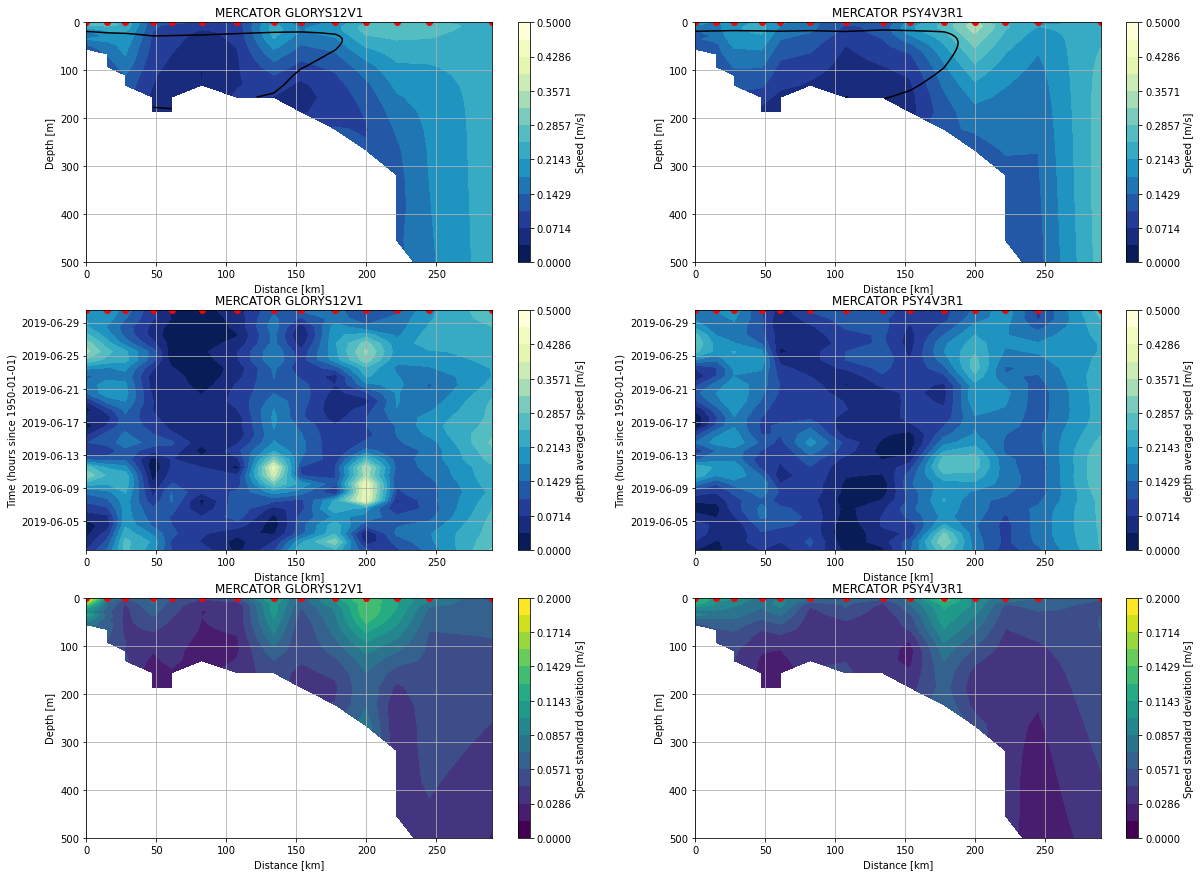

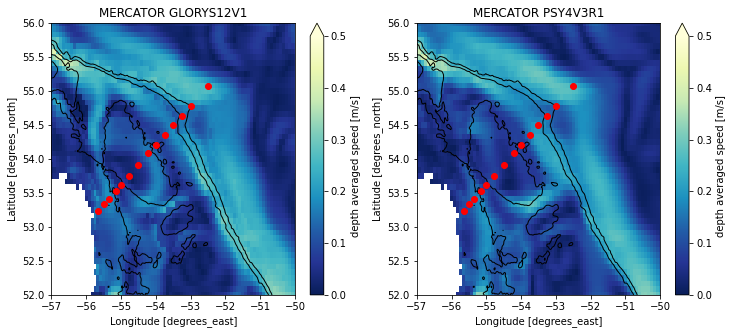

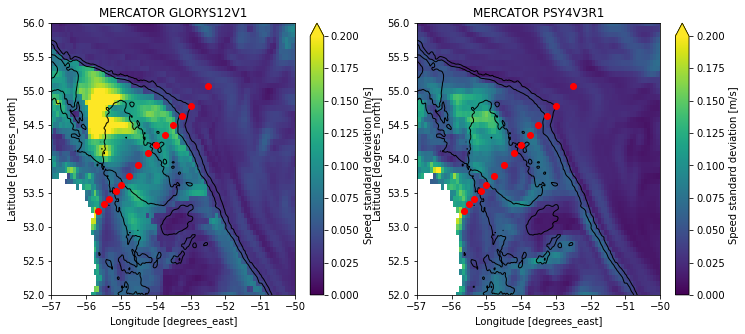

In [12]:
year='2019'
month='06'
plot_month(year,month)

# Monthly mean - July 2019

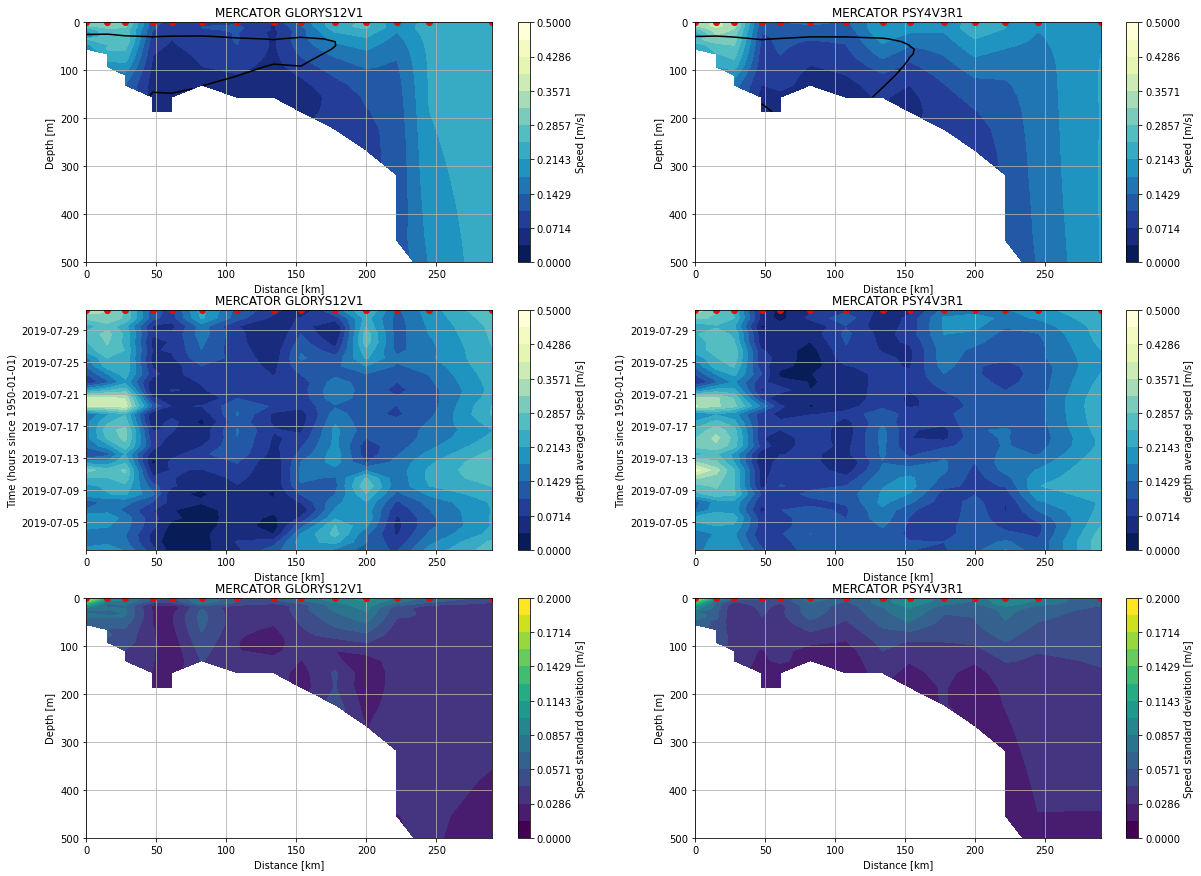

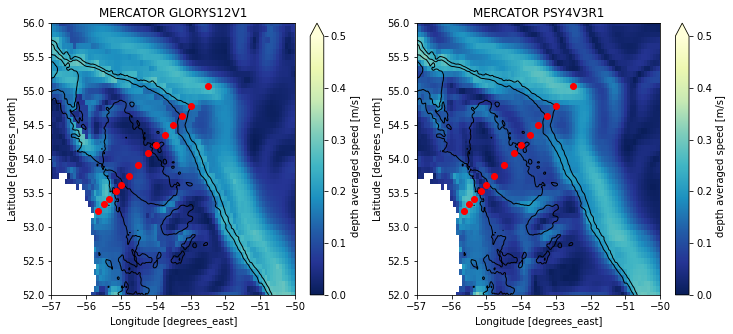

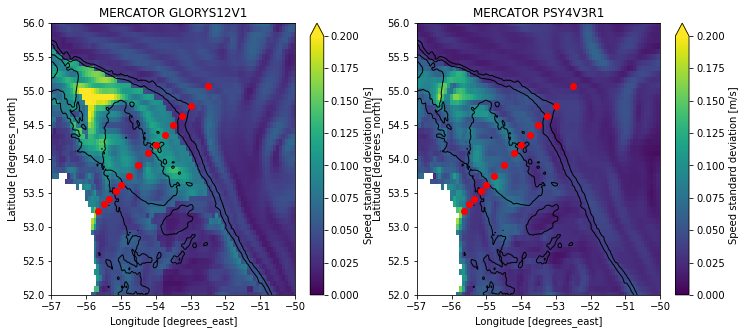

In [13]:
year='2019'
month='07'
plot_month(year,month)

# Monthly Mean - August 2019

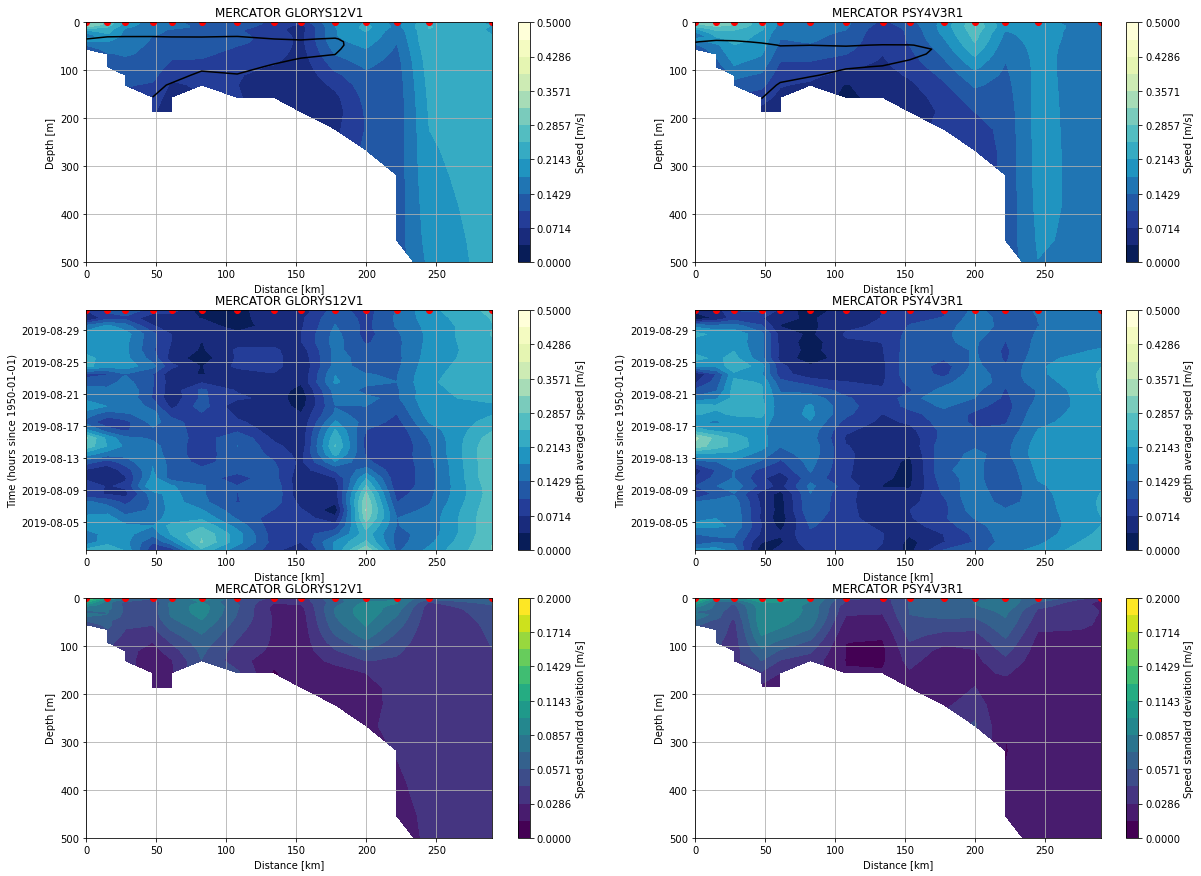

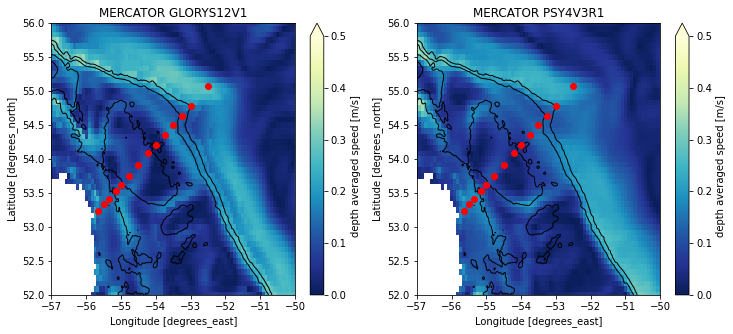

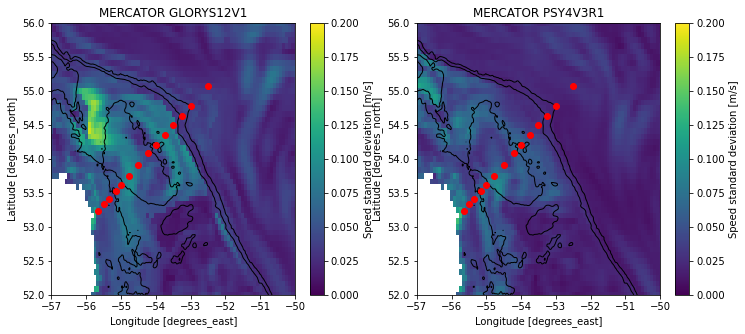

In [14]:
year='2019'
month='08'
plot_month(year,month)

# Surface hovmollers and transects all 2019

In [15]:
year=2019
d_glorys, d_depav_glorys = load_data(year, '*', glorys_path, glorys_coords, glorys_mask, 'glorys_{}'.format(year))
d_psy4, d_depav_psy4 = load_data(year, '*', psy4_path, psy4_coords, psy4_mask,'psy4_{}'.format(year))

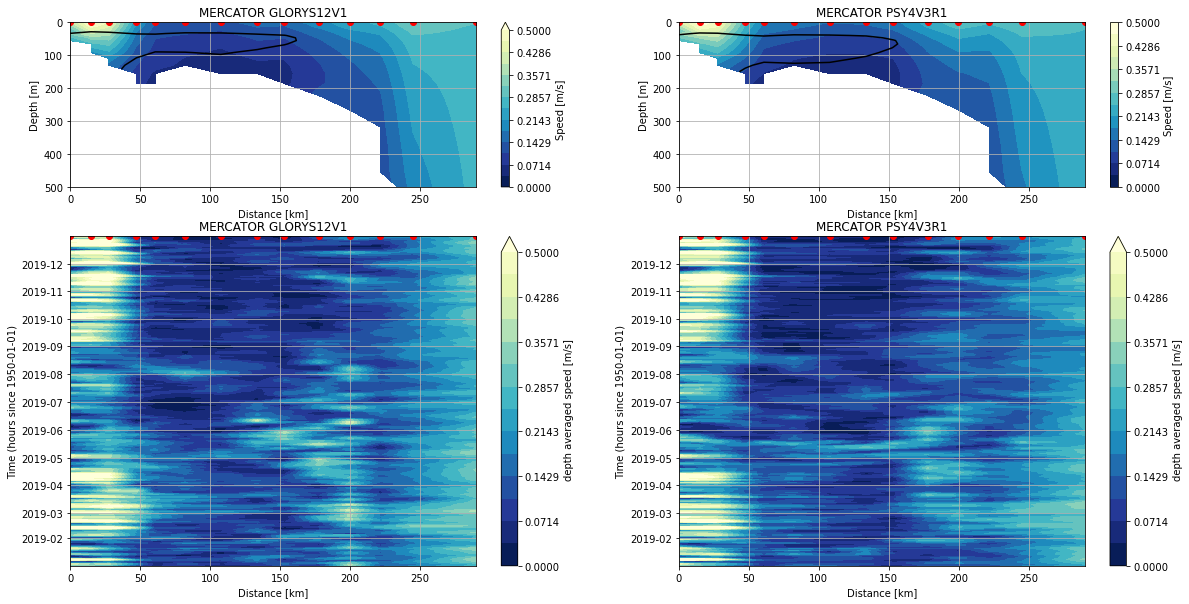

In [16]:
# Transects
from matplotlib.gridspec import GridSpec
fig = plt.figure( figsize=(20,10))
gs = GridSpec(2, 2, height_ratios=[1, 2])
count=0
for d, d_depav in zip([d_glorys, d_psy4], [d_depav_glorys, d_depav_psy4]):
    # mean over time
    ax=fig.add_subplot(gs[0, count])
    dinterp = interp_to_stations(d, STATIONS)
    plot_transect(dinterp.mean(dim='time'), ax)
    ax.set_title(d.source)
    #surface hovmoller
    ax=fig.add_subplot(gs[1,count])
    dinterp_depav = interp_to_stations(d_depav, STATIONS)
    dinterp_depav['speed'].attrs['long_name'] = 'depth averaged speed'
    plot_hovmoller(dinterp_depav, ax, var='speed')
    ax.set_title(d.source)
    count+=1